## Simple Linear Regression with TFP

* THis is based on chapter 5 from the book "Probabilistic Deep Learning with Python"  

* My goal here was to see if i could fit the sigma parameter in the constant sigma model.
 



#### Imports

In [2]:
import tensorflow as tf


import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)




TFP Version 0.24.0
TF  Version 2.16.1


#### Test TFP


In [4]:
dist = tfd.Normal(loc=1.0, scale=0.1)
print('sample   :', dist.sample(3).numpy()) #Samples 3 numbers
print('prob     :',dist.prob((0,1,2)).numpy()) #Calculates the probabilities for positions 0,1,2
print('log_prob :',dist.log_prob((0,1,2)).numpy()) #Same as above just log
print('cdf      :',dist.cdf((0,1,2)).numpy()) #Calculates the cummulative distributions
print('mean     :',dist.mean().numpy()) #Returns the mean of the distribution
print('stddev   :',dist.stddev().numpy())

sample   : [1.0084225 0.9139096 1.0378124]
prob     : [7.694609e-22 3.989423e+00 7.694609e-22]
log_prob : [-48.616352    1.3836466 -48.616352 ]
cdf      : [7.619854e-24 5.000000e-01 1.000000e+00]
mean     : 1.0
stddev   : 0.1


### Simulate the fishlike data

In the next few cells you will simulate some (x,y)-data where the y increases on average linerly with x but has non-constant variance that so that scatterplot looks like a fish.You will fist simulate random distributed noise with non constant variance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y = 2.7*x+noise (linear slope of 2.7 and intercept of 0). The variance of the noise will change, it starts with a high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance.

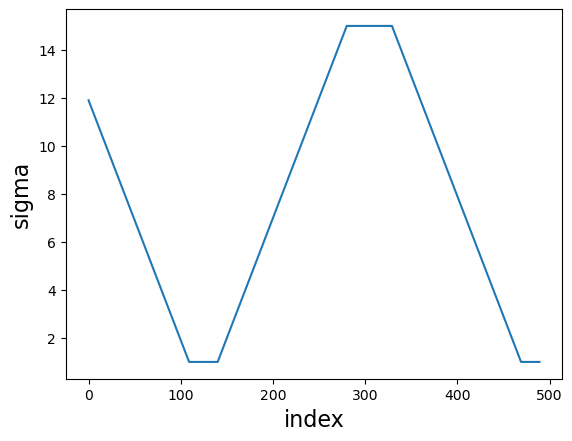

In [5]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()


Now you will sample uniformly distributed x values in the range from -1 to 6. You will sample less x values in the range from -1 to 1. Finally you sort the x values (for ploting reasons).

In [6]:
# generation the x values for the simulated data
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

Let's put it all together to make the simulated fishlike data complete. You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.  

In [7]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [8]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

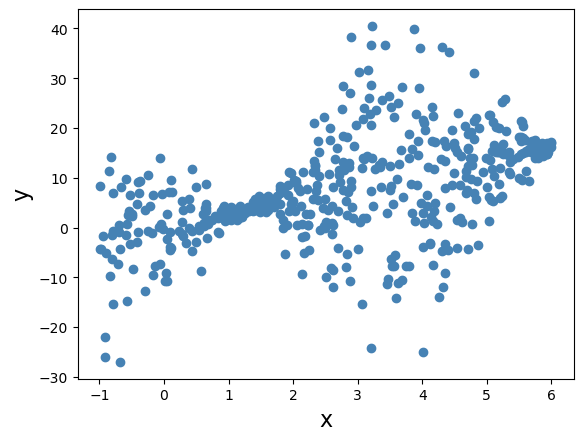

In [9]:
# lets visualize the data
plt.scatter(x,y,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

#### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. To get a first train and test dataset you just randomly sample 25% of the x and y values in the test dataset and the rest is the training dataset. The resulting training dataset gets splitted again into a training and validation dataset (80% training and 20% validation). After the splitting of the dataset you need to make sure that all the x values  from every dataset are in increasing order for ploting reasons (note that you also need to reorder the corresponding y values for all datasets).

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [11]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


Let's plot the training and validation data. You can see that it really looks a bit like a fish. In the following cells you will train different models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model. It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction. That is the reason why you will plot it only in the end.


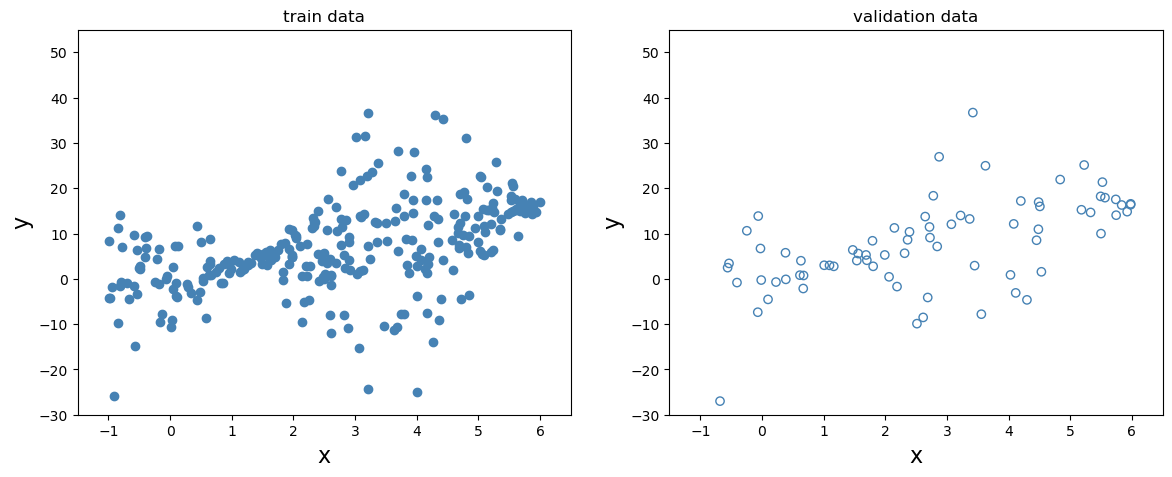

In [12]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,facecolors='none', edgecolors="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.savefig("5.fish.split.pdf")

## Fit a linear regression model with constant variance

In [46]:
# note you have to use the tf_keras NOT tf.keras.   WTF>?

import tf_keras
from tf_keras.layers import Input, Dense, Concatenate
from tf_keras.models import Model
from tf_keras.optimizers import Adam

## Fit a linear regression model and allow the sd to vary

I could not find a better way then defining my own layer with a constant bias.

In [47]:
class Constant_layer(tf_keras.layers.Layer):
    def __init__(self):
        super(Constant_layer, self).__init__()


    def build(self, input_shape):
        # Create weights (trainable variables)
        print(input_shape[-1])
        self.w = self.add_weight(name = "w", shape=[input_shape[-1],1])

    def call(self, inputs):
        # Perform the forward computation
        return tf.multiply(self.w,tf.ones_like(inputs))


In [48]:
def NLL(y, distr):
  return -distr.log_prob(y) #A

def my_dist(params):
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable #C #D

inputs = Input(shape=(1,))
sigma = Constant_layer()(inputs)
 

mu = Dense(1)(inputs) #B
params = Concatenate()([mu,sigma]) #C
 
dist = tfp.layers.DistributionLambda(my_dist)(params) #C #D

model_monotoic_sd = Model(inputs=inputs, outputs=dist)
model_monotoic_sd.compile(Adam(learning_rate=0.01), loss=NLL)

#A Compute NLL of the model
#B Setting up the NN with two output node
#C The first output node defines the mean (loc)
#D The second output defines the standard deviation (scale) via the softplus function

1


In [50]:
model_monotoic_sd.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 1)                    2         ['input_1[0][0]']             
                                                                                                  
 constant_layer (Constant_l  (None, 1)                    1         ['input_1[0][0]']             
 ayer)                                                                                            
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['dense_2[0][0]',         

In [51]:
history = model_monotoic_sd.fit(x_train, y_train, epochs=2000,  validation_data=(x_val,y_val))

Epoch 1/2000


10/10 [==============================] - 1s 29ms/step - loss: 256.2938 - val_loss: 267.4093
Epoch 2/2000
10/10 [==============================] - 0s 3ms/step - loss: 243.4272 - val_loss: 254.5027
Epoch 3/2000
10/10 [==============================] - 0s 3ms/step - loss: 231.3653 - val_loss: 242.4633
Epoch 4/2000
10/10 [==============================] - 0s 3ms/step - loss: 220.2787 - val_loss: 230.8608
Epoch 5/2000
10/10 [==============================] - 0s 3ms/step - loss: 209.3672 - val_loss: 220.1066
Epoch 6/2000
10/10 [==============================] - 0s 3ms/step - loss: 199.4620 - val_loss: 209.8393
Epoch 7/2000
10/10 [==============================] - 0s 3ms/step - loss: 190.0630 - val_loss: 199.9524
Epoch 8/2000
10/10 [==============================] - 0s 3ms/step - loss: 181.4038 - val_loss: 190.5584
Epoch 9/2000
10/10 [==============================] - 0s 4ms/step - loss: 172.7428 - val_loss: 182.1156
Epoch 10/2000
10/10 [==============================] - 0s 3ms/step - loss: 1

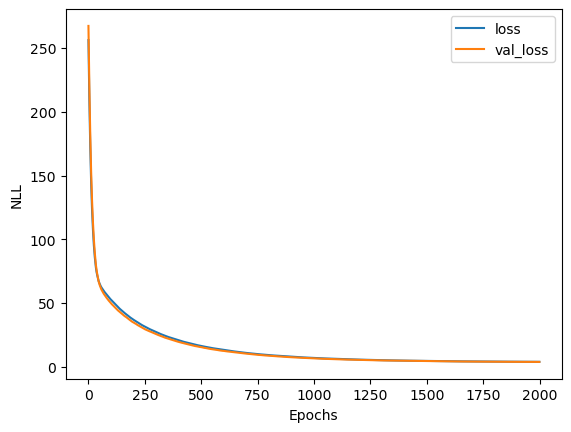

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In the next cell you define two models to predict the mean $\mu$ and the standart deviation $\sigma$ of the output distribution.

In [53]:
# prompt: Extra the trained wieghts form the model
model_monotoic_sd.get_weights()



[array([[2.4238615]], dtype=float32),
 array([0.3131644], dtype=float32),
 array([[112.38065]], dtype=float32)]

In [54]:
distsd = tfp.layers.DistributionLambda( my_dist, convert_to_tensor_fn=tfp.distributions.Distribution.stddev )(params)
distmean = tfp.layers.DistributionLambda( my_dist, convert_to_tensor_fn=tfp.distributions.Distribution.mean )(params)

In [55]:
model_monotoic_sd_mean = Model(inputs=inputs, outputs=distmean)
model_monotoic_sd_sd = Model(inputs=inputs, outputs=distsd)

In [56]:
model_monotoic_sd_sd.predict([6])

1/1 [==============================] - 0s 176ms/step


array([[5.6236544]], dtype=float32)

In [57]:
model_monotoic_sd_mean.predict([7])

1/1 [==============================] - 0s 100ms/step


array([[17.280193]], dtype=float32)

#### Result:  monotonic sigma

In [58]:
print(model_monotoic_sd.evaluate(x_train,y_train, verbose=0))
print(model_monotoic_sd.evaluate(x_val,y_val, verbose=0))

3.801377534866333
3.725921154022217


3/3 [==============================] - 0s 1ms/step


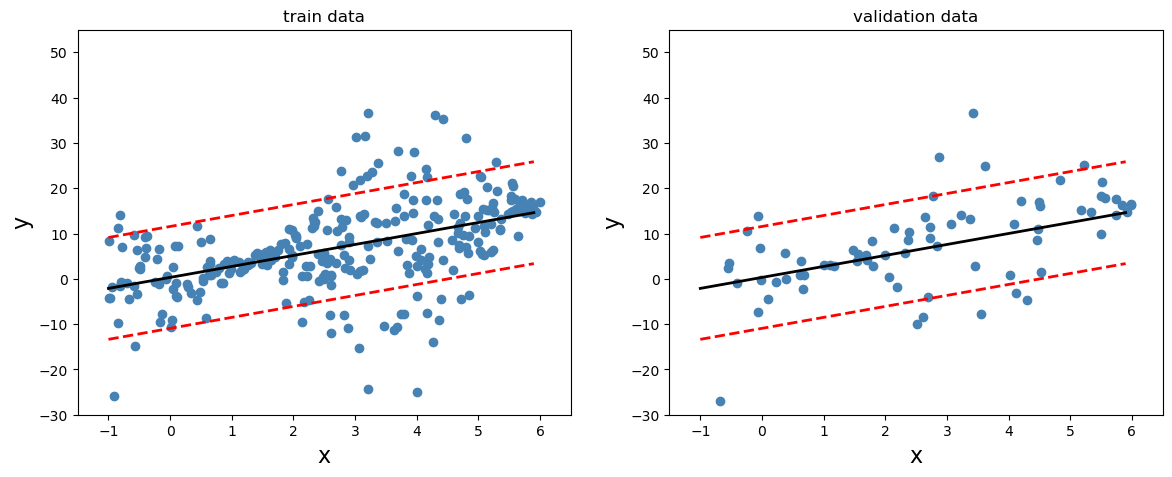

In [59]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd
preds = model_monotoic_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()